<h5>Deep Learning, winter semester 2023/2024, Universität Konstanz</h5>


<h2>E-Mail Spam Detection</h2>

<h3>Svenja Hansing</h3>


<h3>Introduction</h3>

In this digital world, the exachange of e-mails is immense which results in a high amount of spam e-mails which clutter inboxes and pose serious security risks. Spam emails often include deceptive subject lines, numerous advertisements, unauthorized links, or attempts to gather personal information. Adressing this issue, e-mail spam detection became a crucial task because identifying and filtering spam can not only prevent cyber attacks but also enhance the user experience. Thus, training a neural network that is able to automatically detect spam e-mails by categorising e-mail content into spam of non-spam categories turns out to be strikingly useful and needed. 

This project aims to develop a neural network using keras that is able to classify e-mails as spam or non-spam automatically by adressessing binary classification problem. A dataset available on kaggle is used which includes content of multiple e-mails labeld as spam and non-spam(ham). The dataset uses the Enron e-mail dataset that contains approximately 500,000 e-mails gernerated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse. This is the May 7, 2015 Version of dataset, as published at https://www.cs.cmu.edu/~./enron/ The dataset is designed to facilitate the development and evaluation of spam detection or e-mail filtering systems. 


<h3>Data Collection & Pre-processing</h3>

Collecting the data, a publicly available dataset on kaggle is used. As already mentioned the dataset contains e-mails of the Enron dataset. The dataset which is used contains the orignial e-mails and the labels which categorise the e-mail data into spam and non-spam (ham) emails. The categories are changed to numbers for further processing.

For preprocessing the data, the emails are cleaned by removing noisy text, stopwords and non-aphabetic characters. Additionally, characters that might appear in email or web adresses are replaced by strings for detecting and masking appearing e-mail and web adresseses appearing in the e-mails. As the word subject appears in every e-mail, the word is removed. Any further details about the data cleaning steps can be found in the code comments. 

After the data cleaning, the e-mail data get tokenized and transformed into seuqences. Afterwards, the e-mail data is transformed into padded seuqences. As the labels got changed to numbers in earlier steps, they got hot-label encoded later on to fit the models input appropriately.

In [1]:
#importing all required libraries 
import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prettytable import PrettyTable
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, precision_score,recall_score,f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, GlobalAveragePooling1D, LSTM
from tensorflow.keras.utils import to_categorical


2024-02-22 10:08:43.455837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#reading in the dataset
data = pd.read_csv("/compLing/students/courses/deepLearning2324/finalProject/svenja.hansing/email_spam_data.csv")

#giving out the data
data

,email,label
0,Subject: re : rankings\nthank you .,ham
1,"Subject: re : visit to enron\nvince ,\ndec . 2...",ham
2,Subject: research group move to the 19 th floo...,ham
3,Subject: christmas baskets\nthe christmas bask...,ham
4,"Subject: japan candidate\nvince ,\ni spoke wit...",ham
...,...,...
5849,"Subject: tetm : 22 , interest : 3 . 55 %\nha h...",spam
5850,"Subject: localized software , all languages av...",spam
5851,Subject: instant branded software download\nso...,spam
5852,"Subject: localized software , all languages av...",spam


In [3]:
#looking at an example
data["email"][11]

"Subject: imperial capital - thursday schedule\nthe following is the schedule for thursday ' s meeting with imperial capital .\ncurrently all meetings are scheduled in eb 2868 . we are trying to arrange a\ndifferent conference room and will let you know if we obtain one .\n9 : 00 am - jim fallon - electricity\n9 : 30 am - fred lagrasta - gas\n10 : 00 am - lynda clemmons and david kistler - weather\n10 : 30 am - ed ondarza - pulp and paper\n11 : 00 am - stinson gibner - research\n12 noon - lunch\n1 : 00 pm - 5 : 00 pm - discussion\nthanks in advance to all who will come to speak in the morning ."

In [4]:
#renaming the email column (not necessarily required) 
data = data.rename(columns={'email':'mails'})

In [5]:
#looking at the shape of the data
data.shape

(5854, 2)

In [6]:
#observing the data more precisely just to get a better overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5854 entries, 0 to 5853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mails   5854 non-null   object
 1   label   5854 non-null   object
dtypes: object(2)
memory usage: 91.6+ KB


In [7]:
#replacing categories (ham, spam) with numbers for the model
data['labels'] = data['label'].map({'ham':0,
                                    'spam':1})
data['labels']



0       0
1       0
2       0
3       0
4       0
       ..
5849    1
5850    1
5851    1
5852    1
5853    1
Name: labels, Length: 5854, dtype: int64

In [8]:
data['mails']

0                     Subject: re : rankings\nthank you .
1       Subject: re : visit to enron\nvince ,\ndec . 2...
2       Subject: research group move to the 19 th floo...
3       Subject: christmas baskets\nthe christmas bask...
4       Subject: japan candidate\nvince ,\ni spoke wit...
                              ...                        
5849    Subject: tetm : 22 , interest : 3 . 55 %\nha h...
5850    Subject: localized software , all languages av...
5851    Subject: instant branded software download\nso...
5852    Subject: localized software , all languages av...
5853    Subject: microsoft autoroute 2005 dvd uk - $ 1...
Name: mails, Length: 5854, dtype: object

In [9]:
#data cleaning

#nltk.download('stopwords')
stop_words = set(stopwords.words('english')) #defining the stopwords (english) downloaded from nltk


def clean_data(text): #cleaning data function which takes in the text
    text = text.lower() #converts all characters in the text to lowercase
    text = re.sub(r'\n+', ' ', text) #replacing new lines
    text = re.sub(r'\d+', ' ', text) #remove all digits
    text = re.sub(r'[^\w\s]', ' ', text) #replaces every non-word and non-space characters with a space
    text = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'mailaddress', text) #replaces email adresses with the string 'email adress'
    text = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress', text) #replaces url's with the string 'webadress'
    text = re.sub(r'subject', ' ', text) #replaces the word subject which is present in every email header
    text = re.sub(r'\s+', ' ', text).strip() #replaces one or more whitespaces with a single space
    text = ' '.join(word for word in text.split() if word not in stop_words) #tokenizes text into words, removes any stopwords + joins remaining words back into a single string

    return text #returns text


data['mails'] = data.loc[:,'mails'].map(clean_data) #applies the clean data function to the mails column to clean every mail 

print(data['mails']) #prints the cleaned data

0                                          rankings thank
1       visit enron vince dec fine talked shirley dire...
2       research group move th floor hello case feel e...
3       christmas baskets christmas baskets ordered or...
4       japan candidate vince spoke whalley sa offsite...
                              ...                        
5849    tetm interest ha http voj hcdc rote espoeiur u...
5850    localized software languages available hello w...
5851    instant branded software download software sal...
5852    localized software languages available hello w...
5853    microsoft autoroute dvd uk discounted software...
Name: mails, Length: 5854, dtype: object


In [10]:
#tokenizing the text to tranform them to seuquences which get padded then 
tokenizer = Tokenizer() #this tokenizer is used to vectorize the mails into sequences of integers
tokenizer.fit_on_texts(data['mails']) #tokenizer applied to the mails column 
X = tokenizer.texts_to_sequences(data['mails']) #converting the mails into seuqences 
X = np.array(X) #converting list of sequences into a numpy array
X = pad_sequences(X, maxlen=100) #padding or truncating the sequences to make them all the same length which is here 100

/var/folders/pt/7xp3d8tn1h1d7pm_d_3dp5tr0000gn/T/ipykernel_35292/344605855.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X) #converting list of sequences into a numpy array


In [11]:
labels = data['labels'] #assigning labels variable
labels = to_categorical(labels, dtype ="uint8") #converting categorical labels into one-hot encoded vectors to make them fit the model
print(labels)

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [12]:
#splitting the dataset into test and train data with a test size of 0.2 and a random state of 42
X_train, X_test, y_train, y_test = train_test_split(X , data['labels'], test_size = 0.2, random_state = 42)

#observing the shapes
X_train.shape 
y_train.shape

(4683,)

<h3>Creating & Training the model</h3>

For creating a suitable neural network/language model for email spam detection, keras is used. More precisely, in the follwoing models, sequential calls for Keras sequential model in which layers are added in a sequence. By finding the best fit model for the task, various adjustments of the parameters and different choices of layers are applied. Moreover, varying dropout rates and activation functions are applied. When fitting the models, early stoppting is included which stops training if after three epochs the validation loss does not decrease. This prevent overfitting if training the models. All models are evaluated with the accuracy metrics to ensure an even comparison.

These experimentations can be found in the follwoing. 

<h5>Model 1</h5>

- For creating a first mode, a really simple one is used. 

- The vocabulary size is defined based on the tokenizer word index. 

- Embedding layer maps each word to a N-dimensional vector of real numbers. This layer uses a embedding dimension of 24 which is the size of this vector. It indicates that two words with a similar meaning tend to have a very close vectors. As it is the fist hidden layer in the model architecture, the shape of the input layer is defined by the input length which is the maximum lengt of 100. 

- A relu activation function and a sigmoind activation function as final output layer. The sigmoind layer and the single output neuron is used since only two classes (ham and spam) are used for classification. The sigmoid activation function gives out probabilities between 0 and 1. 

- For compiling the model, the binary crossentropy as loss function, adam optimizer (momentum) and a accuracy metrics is used. The binary crossentropy is used since we have a binary classification task. The accuracy measures the model perfomance on its accuracy.

In [13]:
vocab_size = len(tokenizer.word_index) + 1 #defining the vocab_size which represents the total number of unique words + accounting for special tokens

#sequential model
model = Sequential()

#adding layers as described above 
model.add(Embedding(vocab_size, 24, input_length=100)) 
model.add(Dense(56, activation = 'relu')) 
model.add(Dense(1, activation = 'sigmoid')) 

#compiling the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

#creating model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 24)           866736    
                                                                 
 dense (Dense)               (None, 100, 56)           1400      
                                                                 
 dense_1 (Dense)             (None, 100, 1)            57        
                                                                 
Total params: 868193 (3.31 MB)
Trainable params: 868193 (3.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
#early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#fitting the model with 30 epochs, a batch size of 64 and validation data which is the test data
#the same is applied to all models to have an even comparison
history = model.fit(X_train, y_train, epochs = 30, batch_size = 64, validation_data = [X_test, y_test], callbacks = [early_stop])

Epoch 1/30
74/74 [==============================] - 1s 8ms/step - loss: 0.6229 - accuracy: 0.7297 - val_loss: 0.5394 - val_accuracy: 0.7416
Epoch 2/30
74/74 [==============================] - 0s 6ms/step - loss: 0.4773 - accuracy: 0.7776 - val_loss: 0.4646 - val_accuracy: 0.7774
Epoch 3/30
74/74 [==============================] - 0s 6ms/step - loss: 0.4303 - accuracy: 0.8005 - val_loss: 0.4541 - val_accuracy: 0.7790
Epoch 4/30
74/74 [==============================] - 0s 6ms/step - loss: 0.4171 - accuracy: 0.8040 - val_loss: 0.4521 - val_accuracy: 0.7791
Epoch 5/30
74/74 [==============================] - 0s 6ms/step - loss: 0.4120 - accuracy: 0.8044 - val_loss: 0.4517 - val_accuracy: 0.7788
Epoch 6/30
74/74 [==============================] - 1s 7ms/step - loss: 0.4092 - accuracy: 0.8037 - val_loss: 0.4523 - val_accuracy: 0.7784
Epoch 7/30
74/74 [==============================] - 0s 6ms/step - loss: 0.4065 - accuracy: 0.8043 - val_loss: 0.4524 - val_accuracy: 0.7782
Epoch 8/30
74/74 [==

<h5>Model 2</h5>

The same as in the first model but adding a flatten layer and increasing the dimensions of the relu activation function.

In [15]:
vocab_size = len(tokenizer.word_index) + 1

model1 = Sequential()

model1.add(Embedding(vocab_size, 24, input_length=100))
model1.add(Flatten(input_shape = X_train.shape[1:])) #flatten layer and specifying the input shape (excluding batch dimension)
model1.add(Dense(128, activation = 'relu')) #increased dimensionality
model1.add(Dense(1, activation = 'sigmoid'))

model1.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 24)           866736    
                                                                 
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               307328    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1174193 (4.48 MB)
Trainable params: 1174193 (4.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history1 = model1.fit(X_train, y_train, epochs = 30, batch_size = 64, validation_data = [X_test, y_test], callbacks = [early_stop])

Epoch 1/30
74/74 [==============================] - 1s 9ms/step - loss: 0.3802 - accuracy: 0.8354 - val_loss: 0.0855 - val_accuracy: 0.9787
Epoch 2/30
74/74 [==============================] - 1s 7ms/step - loss: 0.0251 - accuracy: 0.9959 - val_loss: 0.0444 - val_accuracy: 0.9795
Epoch 3/30
74/74 [==============================] - 1s 9ms/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.0374 - val_accuracy: 0.9829
Epoch 4/30
74/74 [==============================] - 1s 7ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0337 - val_accuracy: 0.9855
Epoch 5/30
74/74 [==============================] - 1s 7ms/step - loss: 8.8021e-04 - accuracy: 0.9998 - val_loss: 0.0355 - val_accuracy: 0.9838
Epoch 6/30
74/74 [==============================] - 1s 8ms/step - loss: 5.1388e-04 - accuracy: 1.0000 - val_loss: 0.0350 - val_accuracy: 0.9838
Epoch 7/30
74/74 [==============================] - 1s 7ms/step - loss: 3.7156e-04 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9838


<h5>Model 3</h5>

In this model a dropout rate of 0.5 is added to see how the model performs here. 

In [17]:
model2 = Sequential()

model2.add(Embedding(vocab_size, 24, input_length=100))
model2.add(Flatten(input_shape = X_train.shape[1:]))
model2.add(Dense(28, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(28, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 24)           866736    
                                                                 
 flatten_1 (Flatten)         (None, 2400)              0         
                                                                 
 dense_4 (Dense)             (None, 28)                67228     
                                                                 
 dropout (Dropout)           (None, 28)                0         
                                                                 
 dense_5 (Dense)             (None, 28)                812       
                                                                 
 dropout_1 (Dropout)         (None, 28)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)


history2 = model2.fit(X_train, y_train, epochs = 30, batch_size = 64, validation_data = [X_test, y_test], callbacks = [early_stop])

Epoch 1/30
74/74 [==============================] - 1s 6ms/step - loss: 0.6098 - accuracy: 0.7102 - val_loss: 0.4411 - val_accuracy: 0.7412
Epoch 2/30
74/74 [==============================] - 0s 5ms/step - loss: 0.2635 - accuracy: 0.8512 - val_loss: 0.0788 - val_accuracy: 0.9821
Epoch 3/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0439 - accuracy: 0.9938 - val_loss: 0.0349 - val_accuracy: 0.9855
Epoch 4/30
74/74 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.0436 - val_accuracy: 0.9829
Epoch 5/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0103 - accuracy: 0.9977 - val_loss: 0.0541 - val_accuracy: 0.9812
Epoch 6/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0447 - val_accuracy: 0.9863


<h5>Model 4</h5>

Here is a shallow neural network architecture including a GlobalAveragePooling1D layer. This layer reduces the number of parameters in the model and is able to avoid overfitting. It averages across the data which lead to better representations of the vector. 

In [19]:
model3 = Sequential() #sequential model

model3.add(Embedding(input_dim=vocab_size, output_dim= 16, input_length=100)) #embedding layer
model3.add(GlobalAveragePooling1D()) #global average pooling layer
model3.add(Dense(24, activation='relu')) #relu activation function 
model3.add(Dropout(0.2)) #dropout rate
model3.add(Dense(1, activation='sigmoid')) #single output neuron + sigmoid activation function because there are only two classes (ham/spam)

#compiling model as before
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           577824    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_7 (Dense)             (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 25        
                                                                 
Total params: 578257 (2.21 MB)
Trainable params: 578257 (2.21 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)


history3 = model3.fit(X_train, y_train, epochs = 30, batch_size = 64, validation_data = [X_test, y_test], callbacks = [early_stop])

Epoch 1/30
74/74 [==============================] - 1s 5ms/step - loss: 0.6249 - accuracy: 0.7435 - val_loss: 0.5492 - val_accuracy: 0.7370
Epoch 2/30
74/74 [==============================] - 0s 4ms/step - loss: 0.4596 - accuracy: 0.7529 - val_loss: 0.3798 - val_accuracy: 0.7694
Epoch 3/30
74/74 [==============================] - 0s 3ms/step - loss: 0.2889 - accuracy: 0.8708 - val_loss: 0.2413 - val_accuracy: 0.9044
Epoch 4/30
74/74 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9639 - val_loss: 0.1560 - val_accuracy: 0.9795
Epoch 5/30
74/74 [==============================] - 0s 3ms/step - loss: 0.1043 - accuracy: 0.9898 - val_loss: 0.1031 - val_accuracy: 0.9821
Epoch 6/30
74/74 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9964 - val_loss: 0.0775 - val_accuracy: 0.9821
Epoch 7/30
74/74 [==============================] - 0s 3ms/step - loss: 0.0433 - accuracy: 0.9970 - val_loss: 0.0641 - val_accuracy: 0.9846
Epoch 8/30
74/74 [==

<h5>Model 5</h5>

This model uses an addtirional LSTM layer.

In [21]:
model4 = Sequential()

model4.add(Embedding(vocab_size, 24, input_length=100))
model4.add(LSTM(25, dropout=0.5, return_sequences=True))
model4.add(LSTM(25, dropout=0.5, return_sequences=True))

model4.add(Dense(1, activation='sigmoid'))

#compiling model as before
model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 24)           866736    
                                                                 
 lstm (LSTM)                 (None, 100, 25)           5000      
                                                                 
 lstm_1 (LSTM)               (None, 100, 25)           5100      
                                                                 
 dense_9 (Dense)             (None, 100, 1)            26        
                                                                 
Total params: 876862 (3.34 MB)
Trainable params: 876862 (3.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)


history4 = model4.fit(X_train, y_train, epochs = 30, batch_size = 64, validation_data = [X_test, y_test], callbacks = [early_stop])

Epoch 1/30
74/74 [==============================] - 7s 56ms/step - loss: 0.5253 - accuracy: 0.7577 - val_loss: 0.3276 - val_accuracy: 0.8584
Epoch 2/30
74/74 [==============================] - 4s 48ms/step - loss: 0.2785 - accuracy: 0.8717 - val_loss: 0.2635 - val_accuracy: 0.8767
Epoch 3/30
74/74 [==============================] - 3s 47ms/step - loss: 0.2224 - accuracy: 0.8937 - val_loss: 0.2460 - val_accuracy: 0.8847
Epoch 4/30
74/74 [==============================] - 4s 48ms/step - loss: 0.2119 - accuracy: 0.8965 - val_loss: 0.2538 - val_accuracy: 0.8842
Epoch 5/30
74/74 [==============================] - 4s 48ms/step - loss: 0.2002 - accuracy: 0.9004 - val_loss: 0.2599 - val_accuracy: 0.8848
Epoch 6/30
74/74 [==============================] - 4s 48ms/step - loss: 0.1961 - accuracy: 0.9022 - val_loss: 0.2708 - val_accuracy: 0.8837


<h3>Evaluation of the models</h3>

This section evaluates the created models and demonstrates which one performs best. Thereby, the models are compared to each other. The performance of the best model is visualised. 

By assessing the model performances, the accuracy is calculated to determine how well the models predict the test data based on the training data. 

- Model Evaluation is done by calling the model.evaluate function to see how the model performed on the test data. Thereby, the average test loss and accuracy is calculated.


In [30]:
#comparing all models

print(f"Model1: {model.evaluate(X_test, y_test)} " )
print(f"Model2: {model1.evaluate(X_test, y_test)} " )
print(f"Model3: {model2.evaluate(X_test, y_test)} " )
print(f"Model4: {model3.evaluate(X_test, y_test)} " )
print(f"Model5: {model4.evaluate(X_test, y_test)} " )

37/37 [==============================] - 0s 2ms/step - loss: 0.4527 - accuracy: 0.7792
Model1: [0.45265844464302063, 0.7792057394981384] 
37/37 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9838
Model2: [0.03410792350769043, 0.9837745428085327] 
37/37 [==============================] - 0s 1ms/step - loss: 0.0447 - accuracy: 0.9863
Model3: [0.04466761276125908, 0.9863364696502686] 
37/37 [==============================] - 0s 845us/step - loss: 0.0447 - accuracy: 0.9821
Model4: [0.04466528072953224, 0.9820666313171387] 
37/37 [==============================] - 0s 11ms/step - loss: 0.2708 - accuracy: 0.8837
Model5: [0.27075105905532837, 0.8836806416511536] 


In [29]:
#create a table with PrettyTable 
table = PrettyTable()

#define table columns
table.field_names = ["Model", "Loss", "Accuracy"]

#wirting the evaluation of the models in a result dictionary for creating the table 
results = {
    "Model1": model.evaluate(X_test, y_test),
    "Model2": model1.evaluate(X_test, y_test),
    "Model3": model2.evaluate(X_test, y_test),
    "Model4": model3.evaluate(X_test, y_test),
    "Model5": model4.evaluate(X_test, y_test)
}

#add data to the table
for model_name, (loss, accuracy) in results.items():
    table.add_row([model_name, f"{loss:.4f}", f"{accuracy:.4f}"])

#print the table
print("\n Model Evaluation Results:")
print(table)


37/37 [==============================] - 0s 10ms/step - loss: 0.2708 - accuracy: 0.8837

 Model Evaluation Results:
+--------+--------+----------+
| Model  |  Loss  | Accuracy |
+--------+--------+----------+
| Model1 | 0.4527 |  0.7792  |
| Model2 | 0.0341 |  0.9838  |
| Model3 | 0.0447 |  0.9863  |
| Model4 | 0.0447 |  0.9821  |
| Model5 | 0.2708 |  0.8837  |
+--------+--------+----------+


Overall, the table provides a comparative overview of the performance of the five models based on their loss and accuracy metrics on the test data. Model3 stands out with the highest accuracy, representing the highest performance compared to the other models. Model1 has the highest loss and lowest accuracy among the models which indicates the lowest model perfromance. Model5 which includes the LSTM layer also shows low performance compared to the other models. The second model which is a simple neural network architecture with high dimensions seems to be the best fit for the binary classification problem and the e-mail dataset. The performance of the first model can therefore interpreted by its flatness. But important to mention here, Model2-4 reached all high accuracies on the test data meaning that these model all performed good without comparing them. 

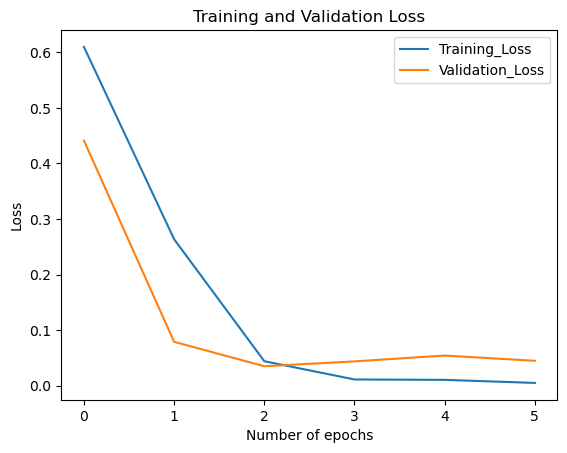

In [32]:
#plotting the best model 

#reading as dataframe
metrics = pd.DataFrame(history2.history)
#rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string) #defining the title
    plt.xlabel ('Number of epochs') #x-axis
    plt.ylabel(string) #y-axis
    plt.legend([var1, var2]) #legend of the plot

#plotting the graphs and label them 
plot_graphs1('Training_Loss', 'Validation_Loss', 'Loss')

This plot shows the training and validation loss of the best model over the epochs. What can be seen here is that the model loss strongly decreases during the first two epochs. The validation loss increases different to the training loss after around 2.3 epochs. Thus, the validation loss starts to decrease again whereas the training loss slowly continues to decrease. It seems that the model starts to overfit here. 

In [35]:
#creating confusion matrix and classification report

y_predict = [1 if o > 0.5 else 0 for o in model2.predict(X_test)] #predictions

cf_matrix = confusion_matrix(y_test, y_predict) #confusion matrix

print(classification_report(y_test, y_predict, target_names = ['ham', 'spam'])) #classification report


print('Metrics for best model')
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test,y_predict)*100))
print('Precision: {:.2f}%'.format(precision_score(y_test,y_predict)*100))
print('Recall: {:.2f}%'.format(recall_score(y_test,y_predict)*100))
print('F1 score: {:.2f}%'.format(f1_score(y_test,y_predict)*100))

37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       863
        spam       0.98      0.96      0.97       308

    accuracy                           0.99      1171
   macro avg       0.99      0.98      0.98      1171
weighted avg       0.99      0.99      0.99      1171

Metrics for best model
Accuracy: 98.63%
Precision: 98.34%
Recall: 96.43%
F1 score: 97.38%


This metrics shows the model peformance on the test data and the predictions of the model. It demonstrates also the good performance of model2 which is demonstrated by the plot in the following.

<h4>Confusion Matrix</h4>

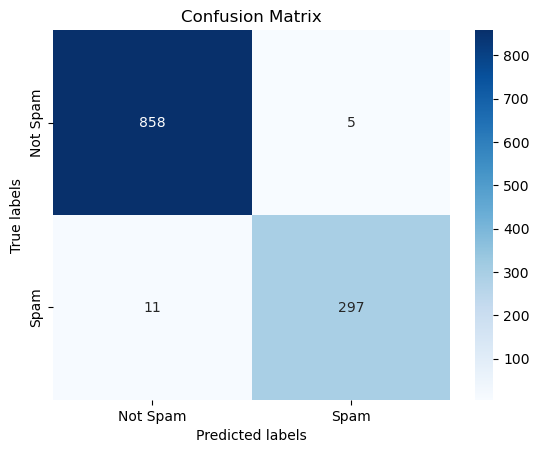

In [36]:
#this code creates a plot of the confusion matrix
ax= plt.subplot()

#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');

#labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

The plot visualises the confusion matrix of the best model. It represents that 858 non-spam labels of the test data are recogized as non-spam which are truly non-spam labels and 297 spam labels are correctly recognised as spam labels. 11 spam and 5 non-spam labels, are wrongly predicted by the model meaning that 11 are predicted wrongly as non spam but are spam and 5 non-spam e-mails are worngly predicted as spam. As visualised here, the model performs quite good on the test data.